In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import requests
import bs4
import time
import re
from fake_useragent import UserAgent

pd.set_option('display.max_columns',101)
pd.options.display.max_columns = 999
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

from IPython.display import Image

## Парсинг датасета с яндекс маркета

In [ ]:
UserAgent().chrome

In [ ]:
data = pd.DataFrame(columns=['+', '-', 'comment','label','rating'])
for page in range (1, 60):
    print ('Страница № ', page)
    time.sleep(3)
    r = requests.get('https://market.yandex.ru/product--smartfon-htc-wildfire-s/7023082/reviews?hid=91491&sort_by=date&page='+str(page),
    headers={'User-Agent': UserAgent().chrome})
    parser = bs4.BeautifulSoup(r.text, 'html')
    # Все отзывы со страницы: 
    p = parser.find_all('div', attrs={'class':'n-product-review-item'})
    reviews = pd.DataFrame(columns=['+', '-', 'comment','label','rating'])
    # Цикл по номеру отзыва на странице:
    for i in range (len(p)):
        texts = (p[i].find_all('dd'))
        len_rev = len(texts)
        
        rating = p[i].find('div', attrs = {'class':'rating__value'}).text
        reviews.loc[i, 'rating']  = rating 
        reviews.loc[i, '+'] = texts[0].text
        
        if (len(texts)) >= 2:
            reviews.loc[i, '-'] = texts[1].text
        if (len(texts)) == 3:
            reviews.loc[i, 'comment'] = texts[2].text
        if int(rating) >= 4:
            label = 'pos'
        else:
            label = 'neg'
        reviews.loc[i, 'label']  = label
 
    data = data.append(reviews)
data.to_csv('final.csv')

In [6]:
train_data = pd.read_csv('final.csv')
train_data.drop(columns = ['Unnamed: 0', 'rating'], inplace = True)
train_data.columns

Index(['+', '-', 'comment', 'label'], dtype='object')

In [7]:
train = pd.DataFrame(columns=['text','label'])
for row in range (len(train_data)):
    if train_data.loc[row, 'label'] =='pos':
        train.loc[row,'text'] = train_data.loc[row,'+']
    else:
        train.loc[row,'text'] = train_data.loc[row,'-'] 
    train.loc[row,'label'] = train_data.loc[row,'label']
train = train.dropna()

In [10]:
train['text'] = train['text'].apply(lambda x: x.replace('\r\n',' '))
train['text'] = train['text'].apply(lambda x: x.replace('\n',' '))
train['text']  = train['text'].map(lambda x:  re.sub(r'\s+',' ',re.sub(r'[^\w\s]','',x).strip()))
#test.text = test.text.map(lambda x:  re.sub(r'\s+',' ',re.sub(r'[^\w\s]','',x).strip()))

## Подготовка тестовой выборки

In [44]:
dataset = pd.read_csv('test.csv','rU',engine = 'python', index_col = False, header = None)
d2 = dataset[0]
out = d2.to_string()
out = out.split('<review>')
d2 = pd.DataFrame(out)
d2 = d2[1:]
test_data = d2[0]
test_data = test_data.apply(lambda x: x.replace('\n',''))
test_data = test_data.str.replace('\d+', '')
test_data = test_data.apply(lambda x: x.replace('</review>',''))
test_data  = test_data .map(lambda x:  re.sub(r'\s+',' ',re.sub(r'[^\w\s]','',x).strip()))
test_data = test_data.to_frame()

In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/olga/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [31]:
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer('russian')
lemm = WordNetLemmatizer()

In [42]:
stemmed_text_train = train['text'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split(' ')]))
lem_text_train = train['text'].map(lambda x: ' '.join([lemm.lemmatize(word) for word in x.split(' ')]))

In [48]:
stemmed_text_test = test_data[0].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split(' ')]))
lem_text_test = test_data[0].map(lambda x: ' '.join([lemm.lemmatize(word) for word in x.split(' ')]))

## Обучение моделей

In [53]:
# Здесь будем использовать (1,2) биграммы.
vectorizer = CountVectorizer(ngram_range=(1,2))
#T = vectorizer.fit_transform(train['text'])
T = vectorizer.fit_transform(stemmed_text_train)

#Y = vectorizer.transform(test_data[0])
Y = vectorizer.transform(stemmed_text_test)

clf2 = LogisticRegression()
clf2.fit(T, train['label'])
pred_2 = clf2.predict(Y)
pred_2_proba = clf2.predict_proba(Y)

clf3 = SGDClassifier(alpha=.001, max_iter=50, penalty="elasticnet", random_state=42)
clf3.fit(T,train['label'])
pred_3 = clf3.predict(Y)

clf5 = LinearSVC()
clf5.fit(T, train['label'])
pred_5 = clf5.predict(Y)

/home/olga/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/olga/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [61]:
import pickle
with open('MultilNB.pkl', 'wb') as fid:
    pickle.dump(clf, fid) 
with open('vectorizer.pkl', 'wb') as fid:
    pickle.dump(vect, fid) 

In [55]:
# обучим еще классификаторы, здесь используем обычный мешок слов. Наивные байесовские классификаторы обычно работают лучше-
# без n-грамм.
clf = MultinomialNB(1)
clf1 = ComplementNB(1)
vect = CountVectorizer()
X = vect.fit_transform(stemmed_text_train)
y = vect.transform(stemmed_text_test)

clf.fit(X, train['label'])
clf1.fit(X, train['label'])
pred = clf.predict(y)
pred_1 = clf1.predict(y)
pred_proba = clf.predict_proba(y)

clf4 = PassiveAggressiveClassifier(random_state=1)
clf4.fit(X, train['label'])
pred_4 = clf4.predict(y)

clf6 = RandomForestClassifier(n_estimators=200, random_state=40)
clf6.fit(X,train['label'])
pred_6_proba = clf6.predict_proba(y)

/home/olga/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [56]:
#Создадим список, в котором находятся индексы, для которых MultinomialNB и ComplementNB дают разные прогнозы.
list_index = list()
for i in range(100):
    if pred[i] != pred_1[i]:
        list_index.append(i)
        
#Используем метод голосования. Если значения прогноза MultinomialNB не совпали с прогнозами всех других классификаторов
#(кроме RandomForest, он понадобится нам в дальнейшем), то мы меняем значение прогноза MultinomialNB.
for i in list_index:
    if pred_1[i]==pred_2[i]==pred_3[i]==pred_4[i]==pred_5[i]:
        pred[i] = pred_1[i]
        
#Теперь создадим список, в котором находятся индексы, для которых MultinomialNB и LogisticRegression дают разные прогнозы.
list_index = list()
for i in range(100):
    if pred[i] != pred_2[i]:
        list_index.append(i)    

#Опять используем метод голосования, как и выше. Теперь еще вдобавок исключим ComplementNB, его мы уже обработали.
for i in list_index:
    if pred_2[i]==pred_3[i]==pred_4[i]==pred_5[i]:
        pred[i] = pred_2[i]
        
#Теперь создадим список, в котором находятся индексы, для которых MultinomialNB не совпадает со всеми из прогнозов
# LinearSVC, SGDClassifier, PassiveAgressiveClassifier
list_index = list()
for i in range(100):
    if pred[i] !=  pred_5[i] == pred_4[i]==pred_3[i]:
        list_index.append(i)
        
#Здесь мы используем вероятности. Если уверенность MultinomialNB и случайного леса меньше 0.775, то мы меняем класс.
for i in list_index:
    if max(pred_proba[i]) < 0.775 and max(pred_6_proba[i]) < 0.775:
        pred[i] = pred_5[i]
        
answer = pd.DataFrame()
answer['Id'] = (test_data.index)-1
answer['y'] = pred

#Запишем ответ
answer['y'].replace(-1, 'neg', inplace = True)
answer['y'].replace(1, 'pos', inplace = True)

answer.to_csv('answer.csv', index=False)

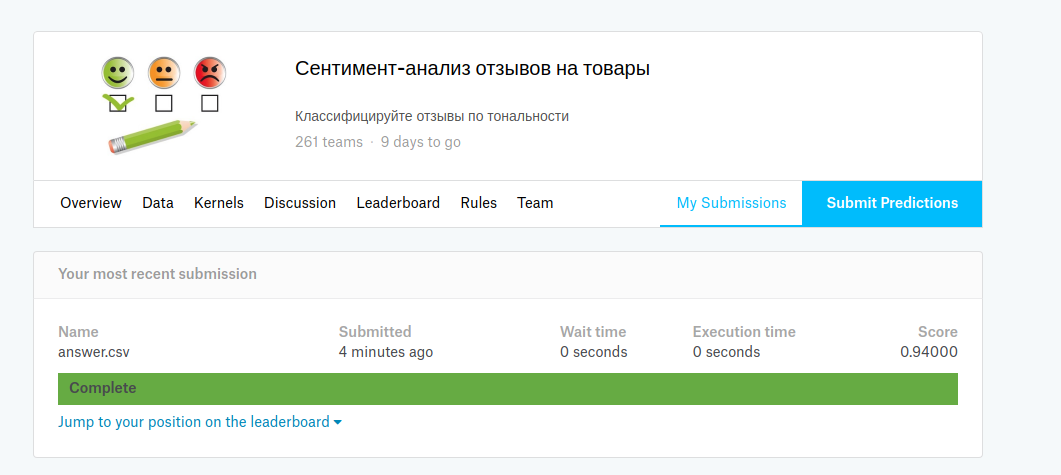

In [57]:
Image(filename='screen1.png') 

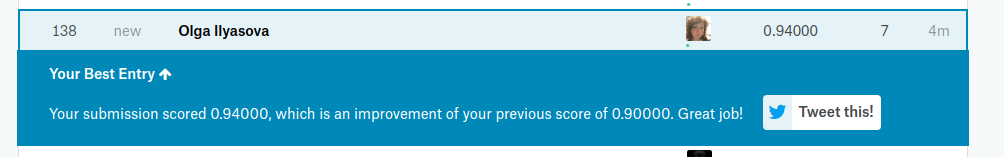

In [58]:
Image(filename='screen2.png')